# Quantum Approximate Optimization Algorithm (QAOA)
This notebook contains a simplified version of the QAOA implementation using Cirq.

In [ ]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq

    print("installed cirq.")

In [ ]:
from typing import Sequence, Tuple
import numpy as np
import sympy
import matplotlib.pyplot as plt

In [ ]:
"""Example of using the ZZ gate."""
# Get two qubits.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

# Pick a value for gamma.
gamma = 0.3

# Display the circuit.
circuit = cirq.Circuit(cirq.ZZ(a, b) ** gamma)
print(circuit)

a: ───ZZ───────
      │
b: ───ZZ^0.3───


In [ ]:
"""Example of using the Z gate."""
# Value of the external magenetic field.
h = 1.3

# Display the circuit.
circuit = cirq.Circuit(cirq.Z(a) ** (gamma * h))
print(circuit)

a: ───Z^0.39───


In [ ]:
def gamma_layer(gamma_value: float, h: np.ndarray) -> Sequence[cirq.Operation]:
    """Generator for U(gamma, C) layer of QAOA

    Args:
        gamma: Float variational parameter for the circuit
        h: Array of floats of external magnetic field values
    """
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i + 1][j]) ** gamma_value
            if j < n_cols - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i][j + 1]) ** gamma_value
            yield cirq.Z(qubits[i][j]) ** (gamma_value * h[i, j])

In [ ]:
def beta_layer(beta_value: float) -> Sequence[cirq.Operation]:
    """Generator for U(beta, B) layer (mixing layer) of QAOA"""
    for row in qubits:
        for qubit in row:
            yield cirq.X(qubit) ** beta_value

In [ ]:
# Definición del problema (rejilla 3x3 Ising)
n_rows, n_cols = 3, 3
h = 0.5 * np.ones((n_rows, n_cols))

# Crear qubits en una cuadrícula
qubits = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]


In [ ]:
"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Your code here!

# Display the QAOA circuit.
qaoa

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(1, 0): ───H───

(1, 1): ───H───

(1, 2): ───H───

(2, 0): ───H───

(2, 1): ───H───

(2, 2): ───H───

In [ ]:
"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Implement the U(gamma, C) operator.
qaoa.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
qaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Display the QAOA circuit.
qaoa

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───
               │        │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───
               │                 │           │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───
               │                 │                     │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───
                        │        │           │         │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───
                        │                              │        │            │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───
                        │                                       │                         │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───
                                                                │            │            │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───
                                                                                          │                     │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───
                                                      └──────────────────┘               └──────────────────┘

In [ ]:
def energy_from_wavefunction(wf, h):
    """Calcula la energía de Ising ⟨ψ|H|ψ⟩ para una rejilla 3x3."""
    n_rows, n_cols = h.shape
    energy = 0.0

    # Recorre todos los estados |z⟩ posibles
    for idx, amp in enumerate(wf):
        # Pasa el índice binario a spins {+1, -1}
        bits = np.array(list(np.binary_repr(idx, width=n_rows * n_cols)), dtype=int)
        spins = 1 - 2 * bits
        spins = spins.reshape((n_rows, n_cols))
        prob = abs(amp) ** 2

        # Energía de Ising clásica
        e = 0
        for i in range(n_rows):
            for j in range(n_cols):
                if i < n_rows - 1:
                    e += spins[i, j] * spins[i + 1, j]
                if j < n_cols - 1:
                    e += spins[i, j] * spins[i, j + 1]
                e += h[i, j] * spins[i, j]
        energy += e * prob

    return energy


In [ ]:
def energy_from_params(
    gamma_value: float, beta_value: float, qaoa: cirq.Circuit, h: np.ndarray
) -> float:
    """Returns the energy given values of the parameters."""
    sim = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    wf = sim.simulate(qaoa, param_resolver=params).final_state_vector
    return energy_from_wavefunction(wf, h)

In [ ]:
"""Do a grid search over values of 𝛄 and β."""
# Set the grid size and range of parameters.
grid_size = 50
gamma_max = 2
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, qaoa, h
        )

In [ ]:
def gradient_energy(
    gamma: float, beta: float, qaoa: cirq.Circuit, h: np.ndarray
) -> Tuple[float, float]:
    """Uses a symmetric difference to calculate the gradient."""
    eps = 10**-3  # Try different values of the discretization parameter

    # Gamma-component of the gradient
    grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
    grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
    grad_g /= 2 * eps

    # Beta-compoonent of the gradient
    grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
    grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
    grad_b /= 2 * eps

    return grad_g, grad_b

In [ ]:
"""Run a simple gradient descent optimizer."""
gamma, beta = 0.2, 0.7  # Try different initializations
eta = 10**-2  # Try adjusting the learning rate.

# Perform gradient descent for a given number of steps.
num_steps = 150
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)

    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 25:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa, h))

Step: 0 Energy: -3.5764041485700773
Step: 25 Energy: -3.797251661467726
Step: 50 Energy: -3.797929438624351
Step: 75 Energy: -3.7981535287158295
Step: 100 Energy: -3.798231860776923
Step: 125 Energy: -3.7982573253800638
Step: 150 Energy: -3.798266776918581

Learned gamma: 0.19715499751687277
Learned beta: 0.7696222105349164


In [ ]:
"""Add measurements to the QAOA circuit."""
measurement_circuit = qaoa.copy()
measurement_circuit.append(
    cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
)
measurement_circuit

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ───────ZZ───────Z^(0.5*𝛄)──────────────────────────────────────────────────────────────────────────────────────────────X^(β)───M('m')───
               │        │                                                                                                                       │
(0, 1): ───H───┼────────ZZ^(𝛄)───ZZ──────────ZZ────────Z^(0.5*𝛄)────────────────────────────────────────────────────────────────────────X^(β)───M────────
               │                 │           │                                                                                                  │
(0, 2): ───H───┼─────────────────┼───────────ZZ^(𝛄)────ZZ────────────────────Z^(0.5*𝛄)──────────────────────────────────────────────────X^(β)───M────────
               │                 │                     │                                                                                        │
(1, 0): ───H───ZZ^(𝛄)───ZZ───────┼───────────ZZ────────┼────────Z^(0.5*𝛄)───────────────────────────────────────────────────────────────X^(β)───M────────
                        │        │           │         │                                                                                        │
(1, 1): ───H────────────┼────────ZZ^(𝛄)──────ZZ^(𝛄)────┼────────ZZ───────────ZZ───────────Z^(0.5*𝛄)─────────────────────────────────────X^(β)───M────────
                        │                              │        │            │                                                                  │
(1, 2): ───H────────────┼──────────────────────────────ZZ^(𝛄)───┼────────────ZZ^(𝛄)───────ZZ────────────────────Z^(0.5*𝛄)───────────────X^(β)───M────────
                        │                                       │                         │                                                     │
(2, 0): ───H────────────ZZ^(𝛄)──────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*𝛄)────────────────────────────X^(β)───M────────
                                                                │            │            │                                                     │
(2, 1): ───H────────────────────────────────────────────────────ZZ^(𝛄)───────ZZ^(𝛄)───────┼─────────────────────ZZ──────────Z^(0.5*𝛄)───X^(β)───M────────
                                                                                          │                     │                               │
(2, 2): ───H──────────────────────────────────────────────────────────────────────────────ZZ^(𝛄)────────────────ZZ^(𝛄)──────Z^(0.5*𝛄)───X^(β)───M────────
                                                      └──────────────────┘               └──────────────────┘

In [ ]:
# --- Simulación con valores concretos de gamma y beta ---
simulator = cirq.Simulator()

# Asignamos valores a las variables simbólicas
params = cirq.ParamResolver({"𝛄": 0.5, "β": 0.3})

# Ejecutamos el circuito con los parámetros resueltos
result = simulator.simulate(qaoa, param_resolver=params)

print("Final state vector:")
print(np.round(result.final_state_vector, 3))



Final state vector:
[-0.005-0.051j -0.004-0.021j  0.043+0.002j  0.012-0.018j -0.004-0.021j
  0.002-0.021j  0.012-0.018j  0.032-0.01j   0.043+0.002j  0.012-0.018j
 -0.028-0.03j   0.055-0.034j  0.01 +0.021j  0.021+0.007j -0.019-0.037j
  0.011+0.02j   0.065+0.009j -0.017-0.049j -0.004+0.012j -0.002+0.043j
 -0.017-0.049j  0.005+0.022j -0.002+0.043j  0.019-0.009j -0.004+0.012j
 -0.002+0.043j  0.023-0.036j  0.009+0.064j  0.038-0.02j   0.054-0.027j
 -0.021-0.023j  0.038-0.018j  0.043+0.002j  0.01 +0.021j -0.028-0.03j
 -0.019-0.037j  0.012-0.018j  0.021+0.007j  0.055-0.034j  0.011+0.02j
  0.035+0.096j -0.024+0.036j  0.036+0.024j  0.042-0.009j -0.024+0.036j
 -0.043+0.031j  0.042-0.009j -0.02 -0.038j -0.004+0.012j  0.038-0.02j
  0.023-0.036j -0.021-0.023j -0.002+0.043j  0.054-0.027j  0.009+0.064j
  0.038-0.018j  0.018+0.037j -0.043+0.009j  0.022+0.002j -0.015-0.028j
 -0.043+0.009j  0.029-0.057j -0.015-0.028j  0.007+0.103j -0.004-0.021j
  0.002-0.021j  0.01 +0.021j  0.021+0.007j  0.069+0.067j  0.

Número detectado de qubits: 9

Top estados más probables:
|101010101>  →  P = 0.0106
|110110110>  →  P = 0.0106
|011011011>  →  P = 0.0106
|000111111>  →  P = 0.0106
|111111000>  →  P = 0.0106
|000101000>  →  P = 0.0105
|010000010>  →  P = 0.0105
|001000100>  →  P = 0.0092
|100000001>  →  P = 0.0092
|100001100>  →  P = 0.0069


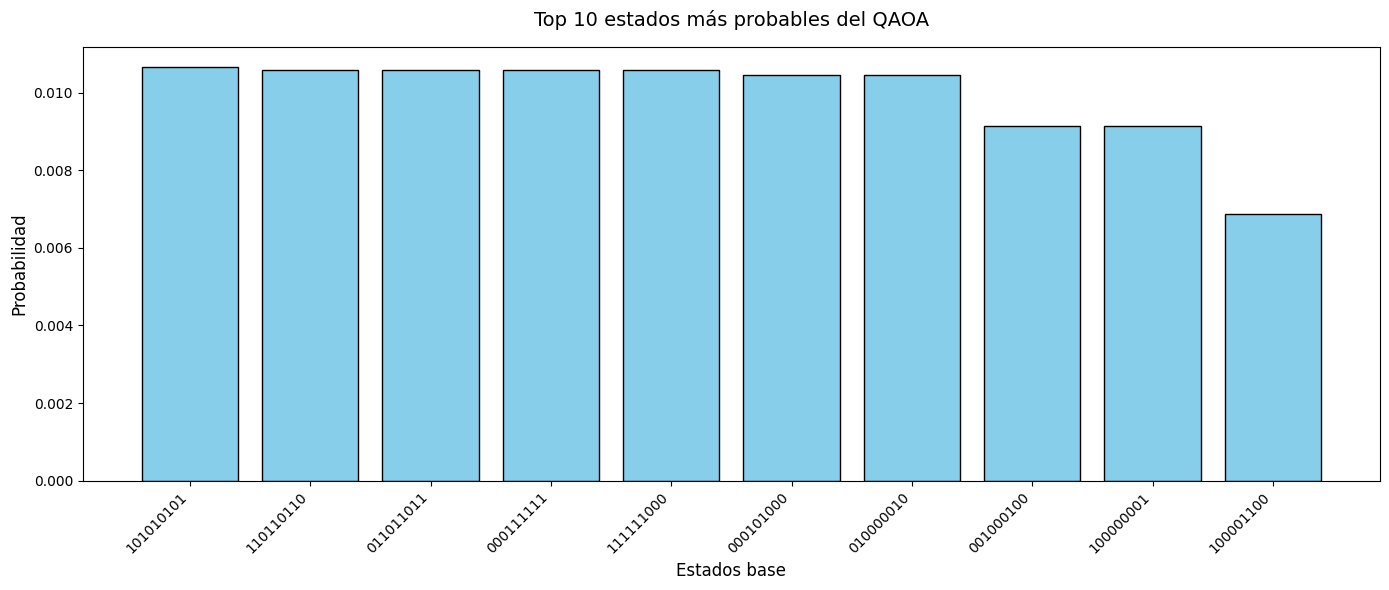

In [ ]:
# Obtener el estado final y calcular probabilidades
final_state = result.final_state_vector
probs = np.abs(final_state) ** 2
sorted_indices = np.argsort(probs)[-10:][::-1]

num_qubits = int(np.log2(len(probs)))

print(f"Número detectado de qubits: {num_qubits}\n")
print("Top estados más probables:")
for idx in sorted_indices:
    bitstring = np.binary_repr(idx, width=num_qubits)
    print(f"|{bitstring}>  →  P = {probs[idx]:.4f}")

# --- Visualización ---
plt.figure(figsize=(14, 6))  # Más ancho
bars = plt.bar(range(10), probs[sorted_indices], color="skyblue", edgecolor="black")

# Etiquetas de estados
plt.xticks(
    range(10),
    [np.binary_repr(i, width=num_qubits) for i in sorted_indices],
    rotation=45,
    ha="right"
)

plt.xlabel("Estados base", fontsize=12)
plt.ylabel("Probabilidad", fontsize=12)
plt.title("Top 10 estados más probables del QAOA", fontsize=14, pad=15)
plt.tight_layout()
plt.show()